In [1]:
import os
import random
import time

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import albumentations as A

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.metrics import *
import scikitplot as skplt

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

def seed_all(s):
    random.seed(s)
    np.random.seed(s)
    tf.random.set_seed(s)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['PYTHONHASHSEED'] = str(s) 

In [3]:
TRAINING_NAME = "HE_EffNetv2-B1"
SEED = 124 
AUTOTUNE = tf.data.experimental.AUTOTUNE

MODEL_NAME = "efficientnetv2-b1-21k-ft1k" 
IMAGE_SIZE = model_image_size_map.get(MODEL_NAME, 224)
BATCH_SIZE = 16
EPOCHS = 20
CLASS_NAMES = ['normal', 'pneumonia', 'COVID-19']

model_handle = model_handle_map.get(MODEL_NAME)
print(f"Selected model : {MODEL_NAME} : {model_handle}")
print(f"Input size     : {IMAGE_SIZE}")

Selected model : efficientnetv2-b1-21k-ft1k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2
Input size     : 240


In [10]:
# Define the augmentation policies
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(p=0.5, limit=15),
    A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.1, 0.1), brightness_by_max=True),
    A.RandomResizedCrop(p=0.5, height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.9, 1.1), ratio=(0.05, 1.1), interpolation=0),
])

# Apply augmentation policies.
def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"] 
    return aug_img

# Augmentation policies
def apply_augmentation(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    aug_img.set_shape((IMAGE_SIZE, IMAGE_SIZE, 3))    
    return aug_img, label

# Preprocess image
def preprocess_data(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image/255.0
    image = tf.squeeze(image, 0) 
    label = tf.squeeze(label, 0) 
    return image, label

# View image from dataset
def view_image(ds, col=8, row=2, size=(25,7)):
    plt.figure(figsize=size)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    for images, labels in ds.take(1):
        for i in range(col*row):
            img_numpy = images[i].numpy()
            ax = plt.subplot(row, col, i + 1)
            shape = str(images[i].numpy().shape)
            plt.imshow(img_numpy)
            plt.title(CLASS_NAMES[np.argmax(labels[i].numpy())])
            plt.axis("off") 
    plt.tight_layout
    return None

# Plot training history
def training_history(history):
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(len(history['loss']))

    plt.figure(figsize=(32, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()
    return None

# Parse test images
def decode_test(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE], antialias=True)/255
    return img

In [6]:
seed_all(SEED)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../dataset/eqhist/train/',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    batch_size = 1,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    shuffle = True,
    seed = SEED,
    interpolation = 'bilinear'
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../dataset/eqhist/valid/',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    batch_size = 1,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    shuffle = True,
    seed = SEED,
    interpolation = 'bilinear'
)

train_ds = (
    train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
    .map(apply_augmentation, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

valid_ds = (
    valid_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

Found 20994 files belonging to 3 classes.
Found 3180 files belonging to 3 classes.


In [7]:
feature_extractor_layer = hub.KerasLayer(model_handle, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), trainable=True)
num_classes = len(CLASS_NAMES)

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              6931124   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 6,934,967
Trainable params: 6,863,895
Non-trainable params: 71,072
_________________________________________________________________


Epoch 1/20
1313/1313 [==============================] - 171s 120ms/step - loss: 0.7943 - accuracy: 0.6553 - precision: 0.6955 - recall: 0.6016 - val_loss: 0.3130 - val_accuracy: 0.8814 - val_precision: 0.8879 - val_recall: 0.8717
Epoch 2/20
1313/1313 [==============================] - 156s 119ms/step - loss: 0.4194 - accuracy: 0.8412 - precision: 0.8537 - recall: 0.8282 - val_loss: 0.3635 - val_accuracy: 0.8604 - val_precision: 0.8770 - val_recall: 0.8453
Epoch 3/20
1313/1313 [==============================] - 176s 134ms/step - loss: 0.3344 - accuracy: 0.8742 - precision: 0.8817 - recall: 0.8650 - val_loss: 0.2157 - val_accuracy: 0.9154 - val_precision: 0.9184 - val_recall: 0.9097
Epoch 4/20
1313/1313 [==============================] - 161s 122ms/step - loss: 0.2877 - accuracy: 0.8929 - precision: 0.9002 - recall: 0.8851 - val_loss: 0.1938 - val_accuracy: 0.9264 - val_precision: 0.9288 - val_recall: 0.9233
Epoch 5/20
1313/1313 [==============================] - 159s 121ms/step - loss: 

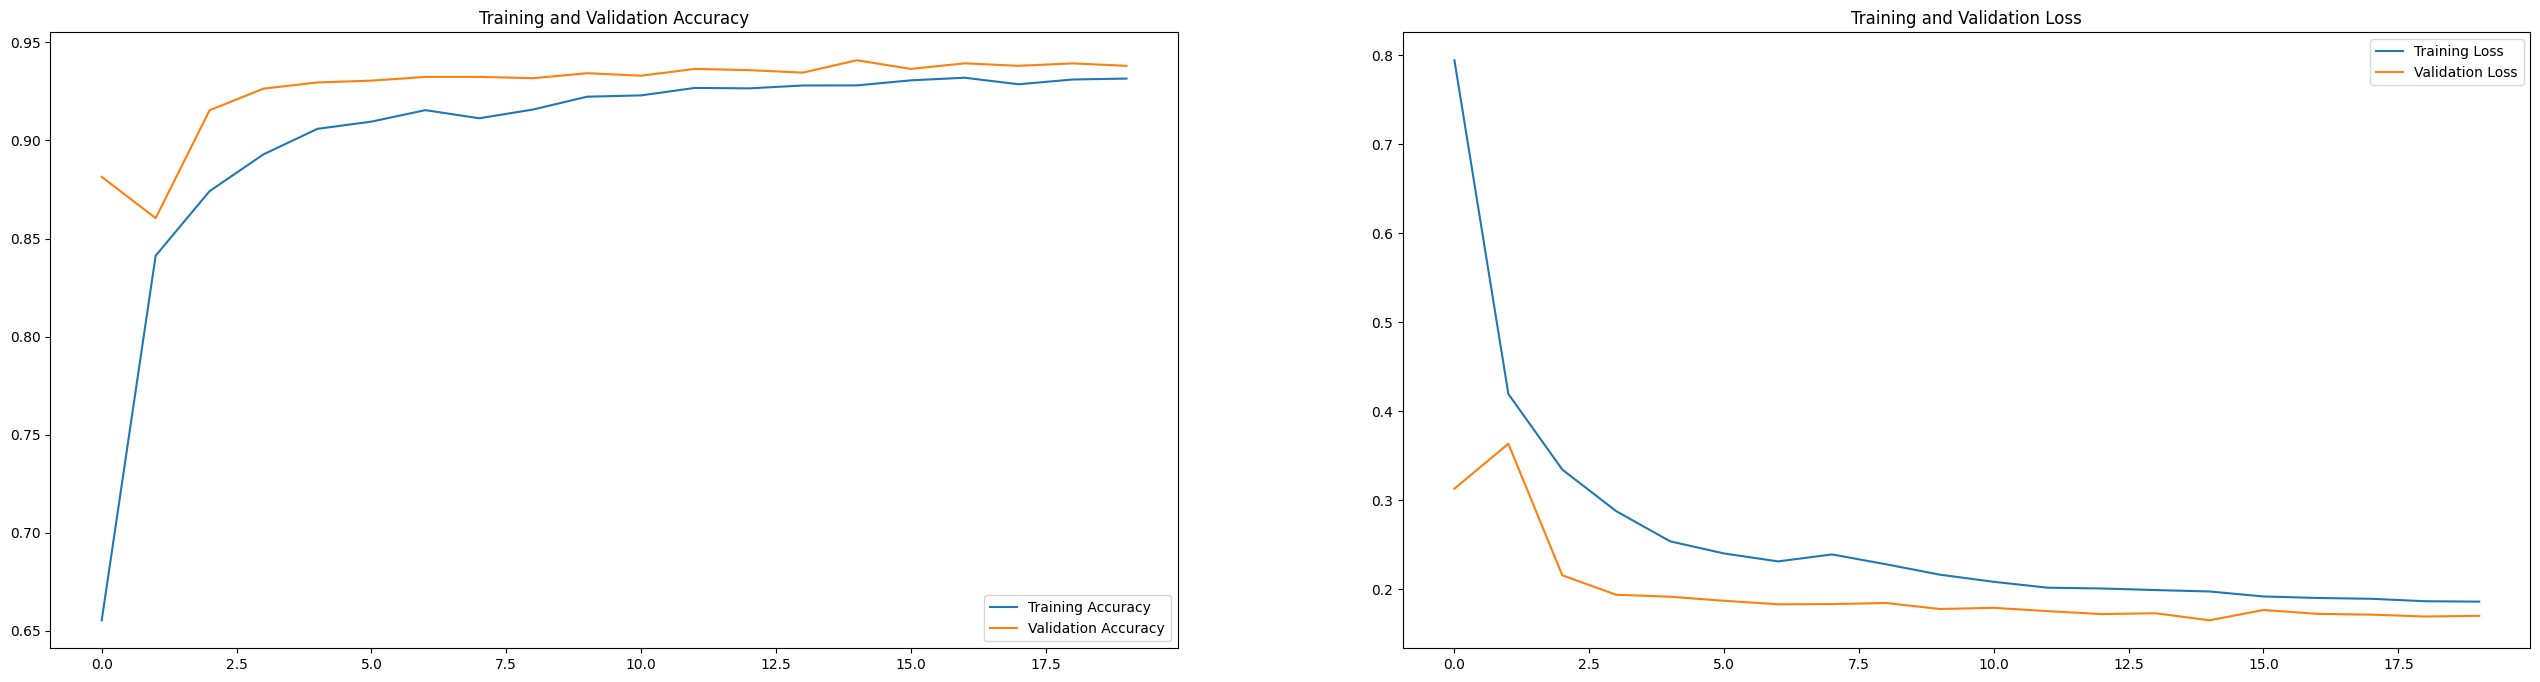

In [8]:
clr_scheduler = tfa.optimizers.CyclicalLearningRate( 
    initial_learning_rate=3e-7,  maximal_learning_rate=7e-3,
    step_size=3*(20994//BATCH_SIZE),  
    scale_fn=lambda x: 1 / (2.0 ** (x - 1)), 
    scale_mode='cycle'
)
    
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

earlyStopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='loss', verbose=1, restore_best_weights=True)

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=clr_scheduler) , 
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=METRICS
)

start_training = time.time()

# train model
history = model.fit(
    train_ds, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[earlyStopping],
    validation_data=valid_ds,
)

end_training = time.time()
print(f"Time taken to train model : {end_training-start_training} sec")

training_history(history.history)

1/1 [==============================] - 0s 427ms/step
Inference time : 0.8991384506225586 sec
              precision    recall  f1-score   support

      normal     0.8899    0.9700    0.9282       100
   pneumonia     0.9681    0.9100    0.9381       100
    COVID-19     0.9897    0.9600    0.9746       100

    accuracy                         0.9467       300
   macro avg     0.9492    0.9467    0.9470       300
weighted avg     0.9492    0.9467    0.9470       300

f1_score        : 0.9466666666666667
accuracy_score  : 0.9466666666666667


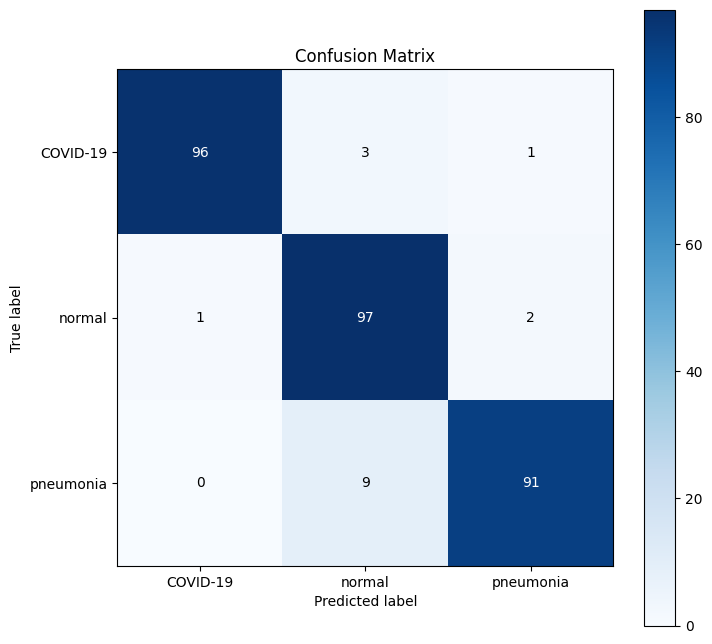

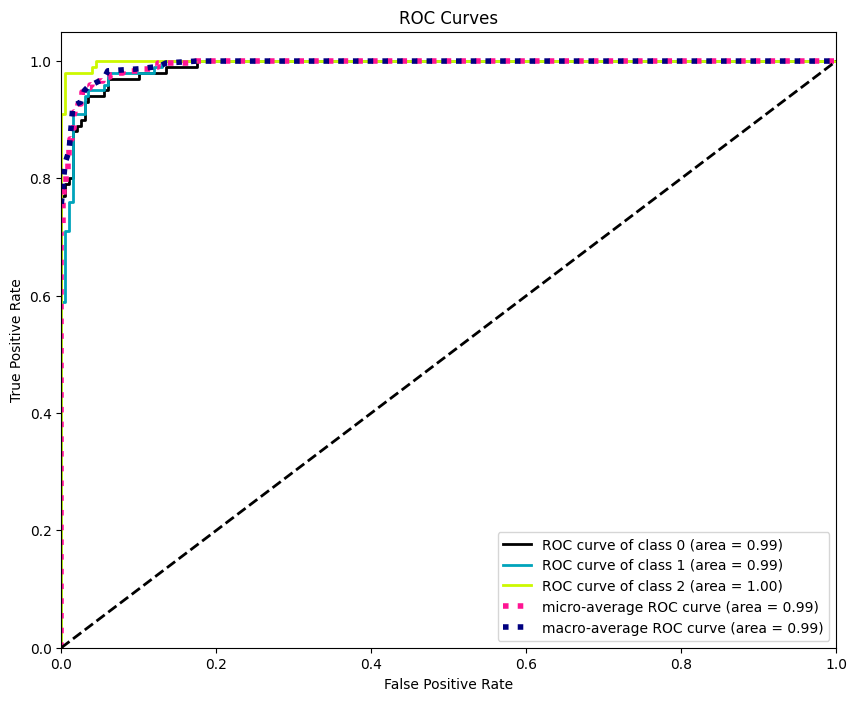

In [12]:
tests_df = pd.read_csv('../dataset/test.csv')
tests_df['path'] = '../dataset/eqhist/test/'+ tests_df.label + '/' + tests_df.filename

test_ds = tf.data.Dataset.from_tensor_slices(tests_df.path) 
test_ds = test_ds.map(decode_test,num_parallel_calls=AUTOTUNE).batch(len(tests_df))

test_index = np.argmax(tests_df[CLASS_NAMES].values, axis=1)
test_label = tests_df.label.values

start_predict = time.time()

test_pred = model.predict(test_ds)
pred_index = np.argmax(test_pred, axis=1)
pred_label = np.array(CLASS_NAMES)[pred_index]

end_predict = time.time()
print(f"Inference time : {end_predict-start_predict} sec")

print(classification_report(test_index, pred_index, target_names=CLASS_NAMES, zero_division=0, digits=4))
print('f1_score        :', f1_score(test_index, pred_index, average='micro'))
print('accuracy_score  :', accuracy_score(test_index, pred_index))

cm = skplt.metrics.plot_confusion_matrix(test_label, pred_label, figsize=(8, 8), normalize=False)
roc = skplt.metrics.plot_roc(test_index, test_pred, figsize=(10,8))

In [13]:
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv("../history/"+TRAINING_NAME+".csv", index=False)
model.save_weights("../model_weight/"+TRAINING_NAME+"_weights.h5")